In [19]:
import numpy as np
from numpy import (mean, std)

import pandas as pd

import random 

from collections import OrderedDict

import string

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import (CountVectorizer,
                                            TfidfTransformer)

import sklearn.neighbors

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import (LogisticRegression,
                                  LogisticRegressionCV)
from sklearn.decomposition import PCA
from sklearn.cluster import (KMeans, spectral_clustering)

import re

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn

seaborn.set(style='ticks')
np.set_printoptions(threshold=10)

[nltk_data] Downloading package stopwords to
[nltk_data]     /cluster/home/erosma01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df_ar = pd.read_json('recipes_raw_nosource_ar.json')
df_epi = pd.read_json('recipes_raw_nosource_epi.json')
df_fn = pd.read_json('recipes_raw_nosource_fn.json')

# Basic Clean Data
One DataFrame with All Data

In [4]:
def clean_data_basic(df):
    id_list = []
    ingredient_list = []
    instruction_list = []
    picture_list = []
    title_list = []
    for key in df:
        str1 = " "
        
        id_list.append(key)

        ingredients = None
        instructions = None
        if type(df[key][0]) is list:
            ingredients = str1.join(df[key][0]).replace("ADVERTISEMENT", "")
        ingredient_list.append(ingredients)
        instruction_list.append(df[key][1])
        picture_list.append(df[key][2])
        title_list.append(df[key][3])
    return pd.DataFrame(data = {'ID': id_list, 'Title': title_list, 
                                'Ingredients': ingredient_list, 'Instructions': instruction_list, 
                                'Picture': picture_list})

In [5]:
# Clean all data and merge into one large dataframe
df_ar_clean = clean_data_basic(df_ar)
df_epi_clean = clean_data_basic(df_epi)
df_fn_clean = clean_data_basic(df_fn)
df = pd.concat([df_ar_clean, df_epi_clean, df_fn_clean], ignore_index = True)
df_filtered = df[['ID', 'Title', 'Ingredients', 'Instructions']].dropna()

# Create Bag of Words

In [6]:
def clean_text(text):
    text = text.replace('ADVERTISEMENT', '')
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    words = letters_only.lower().split()
    meaningful_words = [w for w in words if not w in stopwords.words('english')]
    stemmed_words = [PorterStemmer().stem(w) for w in meaningful_words]
    joined_words = (" ".join(stemmed_words))
    return joined_words
def clean_series(data):
    cleaned_data = []
    i = 0
    for text in data:
        if i%1000 == 0:
            print(i)
        i = i + 1
        cleaned_data.append(clean_text(text))
    return cleaned_data
def create_bag_of_words(clean_data):
    vectorizer = CountVectorizer(analyzer = "word", \
                                 tokenizer = None, \
                                 preprocessor = None, \
                                 stop_words = None, \
                                 ngram_range = (1, 2), \
                                 max_features = 500)
    train_data_features = vectorizer.fit_transform(clean_data).toarray()
    tfidf = TfidfTransformer()
    tfidf_features = tfidf.fit_transform(train_data_features).toarray()
    vocab = vectorizer.get_feature_names()
    return vectorizer, vocab, train_data_features, tfidf_features, tfidf

In [7]:
#recipes_clean is Title, Ingredients, Instructions
#Use first 10000 recipes
df_clean = pd.read_csv('recipes_clean.csv').dropna()[0:10000]
ingredient_train, ingredient_test, \
        recipe_train, recpipe_test = train_test_split(df_clean['Ingredients'], 
                                                        df_clean['Title'], test_size=0.2, random_state=42)


In [8]:
vectorizer, vocab, train_data_features, \
        tfidf_features, tfidf = create_bag_of_words(list(df_clean['Ingredients']))

In [9]:
print(vocab)

['activ', 'activ dri', 'almond', 'appl', 'bacon', 'bake', 'bake powder', 'bake soda', 'banana', 'basil', 'basil teaspoon', 'bay', 'bean', 'bean drain', 'beaten', 'beaten cup', 'beef', 'bell', 'bell pepper', 'black', 'black pepper', 'boneless', 'boneless chicken', 'bottl', 'bouillon', 'bread', 'bread crumb', 'breast', 'breast halv', 'broccoli', 'broth', 'broth cup', 'brown', 'brown sugar', 'bunch', 'butter', 'butter cup', 'butter melt', 'butter soften', 'butter tablespoon', 'butter teaspoon', 'buttermilk', 'cake', 'cake mix', 'can', 'carrot', 'cayenn', 'cayenn pepper', 'celeri', 'cheddar', 'cheddar chees', 'chees', 'chees cup', 'chees ounc', 'chees soften', 'chees tablespoon', 'chees teaspoon', 'chicken', 'chicken breast', 'chicken broth', 'chile', 'chile pepper', 'chili', 'chili powder', 'chip', 'chip cup', 'chocol', 'chocol chip', 'chop', 'chop clove', 'chop cup', 'chop fresh', 'chop green', 'chop onion', 'chop ounc', 'chop pecan', 'chop tablespoon', 'chop teaspoon', 'chop walnut', 'c

# Reduce components

In [207]:
pca = PCA(n_components=2)
x = pca.fit_transform(tfidf_features)
print(sum(pca.explained_variance_ratio_))

0.0971330221416771


# Use K-Means Clustering

In [208]:
kmeans_orig = KMeans(n_clusters=5, random_state=0).fit(tfidf_features)
labels_orig = kmeans_orig.labels_
df_orig = pd.DataFrame(data=df_clean['Title'], columns=['Title'])
df_orig.insert(loc=0, column='Labels',value=labels_orig.transpose())

In [218]:
print(list(df_orig[df_orig['Labels']==3]['Title']))

['Best Chocolate Chip Cookies', 'Banana Banana Bread', "Mom's Zucchini Bread", 'The Best Rolled Sugar Cookies', 'Downeast Maine Pumpkin Bread', 'Best Big, Fat, Chewy Chocolate Chip Cookie', 'To Die For Blueberry Muffins', 'Award Winning Soft Chocolate Chip Cookies', 'Best Brownies', 'Irish Soda Bread', 'Fluffy Pancakes', 'Good Old Fashioned Pancakes', 'Banana Crumb Muffins', 'Easy Sugar Cookies', "Grandmother's Buttermilk Cornbread", "Janet's Rich Banana Bread", 'Big Soft Ginger Cookies', "Mrs. Sigg's Snickerdoodles", 'Carrot Cake III', 'Apple Crisp II', 'Chewy Chocolate Chip Oatmeal Cookies', 'Banana Sour Cream Bread', "Beth's Spicy Oatmeal Raisin Cookies", 'Soft Oatmeal Cookies', "J.P.'s Big Daddy Biscuits", 'Peanut Butter Cup Cookies', 'Iced Pumpkin Cookies', 'Buttermilk Pancakes II', 'Chocolate Chocolate Chip Cookies I', 'Waffles I', 'Simple White Cake', 'Banana Muffins II', 'Zucchini Brownies', 'Classic Peanut Butter Cookies', 'Pumpkin Pancakes', 'One Bowl Chocolate Cake III', 'Go

In [210]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(x)
labels = kmeans.labels_

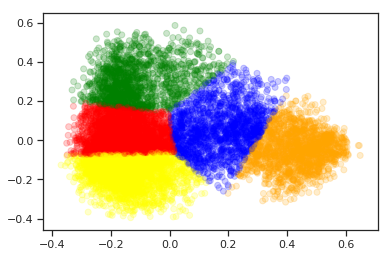

In [211]:
df = pd.DataFrame(data=x, columns=['1','2'])
df.insert(loc=0, column='Labels',value=labels.transpose())
df.insert(loc=3, column='Title', value=df_clean['Title'])
plt.scatter(df['1'], df['2'], alpha=0.2, c=labels, cmap=matplotlib.colors.ListedColormap(['Red', 'Orange', 'Yellow', 'Green', 'Blue']))
plt.show()

In [223]:
print(list(df[df['Labels']==4]['Title']))

['Apple Pie by Grandma Ople', "Chantal's New York Cheesecake", 'Baked Pork Chops I', 'Clone of a Cinnabon', 'Amish White Bread', 'Creamy Rice Pudding', "Annie's Fruit Salsa and Cinnamon Chips", 'Cream Cheese Frosting II', "Jamie's Cranberry Spinach Salad", "Jay's Signature Pizza Crust", 'Sugar Cookie Icing', 'Double Layer Pumpkin Cheesecake', 'Country Apple Dumplings', 'Basic Crepes', 'White Chocolate Raspberry Cheesecake', 'Best Bread Machine Bread', "Grandma's Green Bean Casserole", 'Sweet Restaurant Slaw', 'Sweet Dinner Rolls', 'Pizza Dough I', 'Perfect Pumpkin Pie', 'Peanut Butter Bars I', 'Quick and Easy Pizza Crust', 'Flourless Peanut Butter Cookies', "Grandma Ople's  Apple Pie", "Sarah's Applesauce", 'Mini Meatloaves', 'Best Lemonade Ever', 'Honey Baked Chicken II', "Aunt Teen's Creamy Chocolate Fudge", "Grandma's Lemon Meringue Pie", 'Cranberry Sauce', 'Naan', 'Baklava', 'No Bake Cookies III', 'Simple Whole Wheat Bread', 'Ninety Minute Cinnamon Rolls', 'Fluffy Peanut Butter Fro

In [213]:
print(list(df[df['Labels']==1]['Title']))

['Best Chocolate Chip Cookies', 'Banana Banana Bread', "Mom's Zucchini Bread", 'The Best Rolled Sugar Cookies', 'Downeast Maine Pumpkin Bread', 'Best Big, Fat, Chewy Chocolate Chip Cookie', 'To Die For Blueberry Muffins', 'Award Winning Soft Chocolate Chip Cookies', 'Best Brownies', 'Irish Soda Bread', 'Fluffy Pancakes', 'Good Old Fashioned Pancakes', 'Banana Crumb Muffins', 'Easy Sugar Cookies', "Grandmother's Buttermilk Cornbread", "Janet's Rich Banana Bread", 'Big Soft Ginger Cookies', "Mrs. Sigg's Snickerdoodles", 'Carrot Cake III', 'Apple Crisp II', 'Chewy Chocolate Chip Oatmeal Cookies', 'Banana Sour Cream Bread', "Beth's Spicy Oatmeal Raisin Cookies", "Brooke's Best Bombshell Brownies", 'Fluffy French Toast', 'Soft Oatmeal Cookies', "J.P.'s Big Daddy Biscuits", 'Peanut Butter Cup Cookies', 'Iced Pumpkin Cookies', 'Buttermilk Pancakes II', 'Chocolate Chocolate Chip Cookies I', 'Waffles I', 'Simple White Cake', 'Banana Muffins II', 'Bread Pudding II', 'Yummy Sweet Potato Casserole

In [214]:
print(df[df['Labels']==2])

      Labels         1         2  \
2          2  0.039883 -0.144810   
6          2 -0.201947 -0.206188   
9          2 -0.197344 -0.201210   
13         2 -0.049078 -0.203092   
15         2 -0.068670 -0.195160   
17         2 -0.196191 -0.074295   
20         2 -0.028744 -0.119553   
28         2 -0.154214 -0.127327   
32         2 -0.026286 -0.247246   
33         2 -0.141379 -0.162085   
34         2 -0.263274 -0.115600   
43         2 -0.058479 -0.322658   
44         2 -0.133864 -0.182602   
52         2 -0.040630 -0.090729   
57         2 -0.083360 -0.237936   
61         2 -0.191194 -0.176066   
68         2 -0.169097 -0.278502   
69         2 -0.113009 -0.248770   
74         2 -0.071375 -0.305180   
75         2 -0.031846 -0.136534   
76         2 -0.250490 -0.211572   
79         2 -0.136224 -0.249728   
86         2 -0.188823 -0.172668   
93         2 -0.167625 -0.250352   
96         2  0.062280 -0.237957   
98         2 -0.164208 -0.121931   
102        2 -0.185422 -0.25

In [215]:
print(df[df['Labels']==3])

      Labels         1         2                                     Title
0          3 -0.244073  0.269555         Slow Cooker Chicken and Dumplings
1          3 -0.172235  0.361394             Awesome Slow Cooker Pot Roast
25         3  0.116688  0.283453             Bailey's Irish Cream Brownies
37         3 -0.269594  0.346220             Slow Cooker Chicken Taco Soup
39         3 -0.242757  0.234089                              Baked Ziti I
46         3  0.039736  0.387172                   Too Much Chocolate Cake
53         3 -0.172139  0.356472                       Buffalo Chicken Dip
54         3 -0.149201  0.207260                             Salsa Chicken
55         3 -0.079605  0.161942              Quick and Easy Alfredo Sauce
64         3 -0.121271  0.257985                     Chicken Enchiladas II
72         3 -0.175264  0.225602             Slow Cooker Beef Stroganoff I
81         3 -0.206685  0.441076            Slow Cooker Chicken Stroganoff
82         3 -0.165543  0

In [216]:
#Apps/Small Plates
print(df[df['Labels']==4])

      Labels         1         2  \
26         4  0.232347  0.027133   
31         4  0.267565  0.322652   
35         4  0.022835  0.045298   
45         4  0.345042  0.146183   
49         4  0.137008 -0.029231   
59         4  0.279890  0.023417   
63         4  0.028180  0.015055   
66         4  0.199166  0.360376   
77         4  0.063648 -0.088366   
87         4  0.113389 -0.112972   
97         4  0.160882  0.034386   
99         4  0.148851  0.166949   
110        4  0.112499  0.067563   
117        4  0.233449 -0.007801   
120        4  0.284742  0.309934   
128        4  0.091527  0.062028   
132        4  0.040338  0.116062   
142        4  0.047367 -0.046763   
143        4  0.239495  0.129398   
150        4  0.107761  0.022750   
155        4  0.063506 -0.121529   
164        4  0.172716  0.172175   
165        4  0.044287  0.014116   
177        4  0.259628  0.106360   
183        4  0.243201  0.028663   
184        4  0.162290 -0.084364   
205        4  0.105463  0.07

In [179]:
print(random.choice(list(df[df['Labels']==0]['Title'])), ", ",
      random.choice(list(df[df['Labels']==1]['Title'])), ", ",
      random.choice(list(df[df['Labels']==2]['Title'])), ", ", 
      random.choice(list(df[df['Labels']==3]['Title'])), ", ",
      random.choice(list(df[df['Labels']==4]['Title'])))

Deep Fried Oreos® ,  Baked BBQ Baby Back Ribs ,  Love the Mama Lemon Bars ,  Pita Pizza ,  Chewy Crispy Coconut Cookies


In [166]:
print(vocab[48])
print(tfidf_features[0][48])
print(df_clean['Ingredients'][0])
print(tfidf_features[1][48])

boneless
0.13910941985722908
skinless boneless chicken breast halv tablespoon butter ounc can condens cream chicken soup onion fine dice ounc packag refriger biscuit dough torn piec
0.0


# Spectral Clustering

In [12]:
tfidf_one = []
#get indices of '1's' in tfidf_features
for recipe in tfidf_features:
    output = [idx for idx, element in enumerate(recipe) if element > 0]
    tfidf_one.append(output)
    
tfidf_one = tfidf_one[0:100]

In [13]:
A = []
for i in range(0, len(tfidf_one)):
    if i % 500 == 0:
        print(i)
    row = []
    for j in range(0, len(tfidf_one)):
        sim_count = 0
        if i != j:
            sim_count = len(np.intersect1d(tfidf_one[i], tfidf_one[j]))
        row.append(sim_count)
    A.append(row)

0


In [25]:
A = pd.read_csv('similarity_matrix.csv', header=None)

In [26]:
print(len(A))

10000


In [23]:
A = np.array(A)
labels = spectral_clustering(A, n_clusters=4)

In [24]:
print(labels)

[2 3 1 ... 0 1 3]


# MISC
Create Dataframe with Ingredients and instructions broken up into their own observations

In [ ]:
#Clean data
#Takes in data of Json Format
def extract_quantity(str):
    numbers = []
    for word in str.split():
        if word.isdigit():
            numbers.append(int(word))
    print(numbers)
    quantity = sum(numbers)
    return quantity
def clean_data(df):
    df_ingredients_list = []
    column_list = df.columns
    print(column_list)
    for i in range(0, len(df)):
        ID = df[column_list[0]][i]
        Title = df[column_list[1]][i]
        Ingredients = df[column_list[2]][i]
        Instructions = df[column_list[3]][i]
        Picture = df[column_list[4]][i]
        #Iterate through ingredient list
        for ingredient in Ingredients:
            print("Ingredient: ", ingredient)
            ingredient = ingredient.replace('ADVERTISEMENT', '')
            print(ingredient)
            quantity = extract_quantity(ingredient)
            print(quantity)
        if i > 4:
            break
#     df_ingredients = Dataframe(df_ingredients_list, columns['Title', 'Quantity','Ingredient'])
#     return df_ingredients
recipe_df_1 = clean_data(df)

In [ ]:
clean_ingredient = clean_series(df_filtered['Ingredients'])
clean_instruction = clean_series(df_filtered['Instructions'])
df_clean = pd.DataFrame(data = {'Title': list(df_filtered['Title']), 
                                'Ingredients': clean_ingredient, 
                                'Instructions': clean_instruction})


In [ ]:
vectorizer, vocab, train_data_features, \
        tfidf_features, tfidf = create_bag_of_words(list(df_clean['Instructions']))
print(vocab)

In [ ]:
#Adjacency Matrix
#Construct Degree matrix
D = np.zeros((len(A), len(A)))
for i in range(0, len(A)):
    D[i][i] = sum([1 for x in A[i] if x > 0])

L = D - A
print(L)